In [64]:
#!pip install praw transformers torch
import praw
import pandas as pd
import numpy as np
from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification
import matplotlib.pyplot as plt
import seaborn as sns
import re

In [2]:
user_agent = "Brand sentiment analysis"
reddit = praw.Reddit(
  client_id="ujQpmAa-rxhI6tgE246E4w",
  client_secret="BnhybdI_fallhH64Us6vutIfsXP21Q",
  user_agent=user_agent
)

In [42]:
def fetch_reddit_posts(subreddit, query, limit=100):
    subreddit = reddit.subreddit(subreddit)
    posts = []
    for post in subreddit.search(query, limit=limit):
        if post.selftext and len(post.selftext.split()) > 6 and len(post.selftext.split()) <= 512:  # This checks if the body (selftext) is not empty
          posts.append([post.created_utc, post.title, post.selftext])
    df = pd.DataFrame(posts, columns=["Date", "Title", "Body"])
    df['Date'] = pd.to_datetime(df['Date'], unit='s')
    return df


In [43]:
df_chatgpt = fetch_reddit_posts('all', 'ChatGPT', 100)
df_gemini = fetch_reddit_posts('all', 'Gemini AI', 100)
df_copilot = fetch_reddit_posts('all', 'Copilot AI', 100)

In [45]:
def clean_text(text):
  text = re.sub(r'[^\x00-\x7F]+', ' ', text)
  text = re.sub(r'\s+', ' ', text)
  text = re.sub(r'http\S+', '', text)
  text = re.sub(r'[^\w\s]', '', text)
  return text.lower()

df_chatgpt['Body'] = df_chatgpt['Body'].apply(clean_text)
df_gemini['Body'] = df_gemini['Body'].apply(clean_text)
df_copilot['Body'] = df_copilot['Body'].apply(clean_text)
df_chatgpt['Title'] = df_chatgpt['Title'].apply(clean_text)
df_gemini['Title'] = df_gemini['Title'].apply(clean_text)
df_copilot['Title'] = df_copilot['Title'].apply(clean_text)

In [46]:
df_copilot

,Date,Title,Body
0,2024-03-08 14:40:04,anyone using microsoft copilot ai,my cheap ass company has microsoft dynamics 36...
1,2023-12-10 01:06:42,copilot ai assistant,hello all i was looking for some feedback and ...
2,2024-05-22 13:26:02,ai will replace us all but in the meantime my ...,i work for a 5000 employee company we are bann...
3,2024-03-04 01:06:29,copilot ai max payne 2 cover,i been trying copilot ai asked it to draw a co...
4,2023-09-08 13:16:00,microsoft says it will take the heat if copilo...,microsoft is offering legal protection to com...
5,2024-05-25 17:36:53,copilot ai,odd i asked copilot of it is self aware and if...
6,2024-04-11 18:47:09,which copilotai model for kotlin,i have been brutally unimpressed for copilots ...
7,2024-03-01 08:14:35,microsoft introduces copilot ai chatbot,microsoft recently unveiled its latest innovat...
8,2023-03-16 15:53:39,breaking microsoft announces ai copilot in wor...,microsoft has announced that they are adding a...
9,2024-01-16 10:07:35,microsoft unlocks copilot ai inside office app...,microsoft is making its aipowered copilot ava...


In [49]:
# Load sentiment analysis pipeline
model_name = "distilbert-base-uncased-finetuned-sst-2-english"
tokenizer = AutoTokenizer.from_pretrained(model_name)
sentiment_pipeline = pipeline("sentiment-analysis", model=model_name)

def truncate_text(text, max_tokens=512):
    tokens = tokenizer.tokenize(text)
    if len(tokens) > max_tokens:
        tokens = tokens[:max_tokens]
    return tokenizer.convert_tokens_to_string(tokens)

def get_sentiment_score(text):
    truncated_text = truncate_text(text)
    result = sentiment_pipeline(truncated_text)[0]
    return result['label'], result['score']

# # Apply sentiment analysis to both Title and Body
# def apply_sentiment_analysis(df):
#     df['Title_Sentiment'], df['Title_Sentiment_Score'] = zip(*df['Title'].apply(get_sentiment_score))
#     df['Body_Sentiment'], df['Body_Sentiment_Score'] = zip(*df['Body'].apply(get_sentiment_score))
#     return df

# Apply sentiment analysis
df_chatgpt['Sentiment'], df_chatgpt['Sentiment_Score'] = zip(*df_chatgpt['Body'].apply(get_sentiment_score))
df_gemini['Sentiment'], df_gemini['Sentiment_Score'] = zip(*df_gemini['Body'].apply(get_sentiment_score))
df_copilot['Sentiment'], df_copilot['Sentiment_Score'] = zip(*df_copilot['Body'].apply(get_sentiment_score))

In [67]:
# Combine title and body and apply sentiment analysis
def apply_combined_sentiment_analysis(df):
    df['Combined_Text'] = df['Title'] + " " + df['Body']
    df['Combined_Sentiment'], df['Combined_Sentiment_Score'] = zip(*df['Combined_Text'].apply(get_sentiment_score))
    return df

# Example DataFrames
# Assuming df_chatgpt, df_gemini, df_copilot are already defined and have 'Title' and 'Body' columns
df_chatgpt = apply_combined_sentiment_analysis(df_chatgpt)
df_gemini = apply_combined_sentiment_analysis(df_gemini)
df_copilot = apply_combined_sentiment_analysis(df_copilot)

In [68]:
# Display sentiment statistics
print("ChatGPT Sentiment Statistics:")
print(df_chatgpt['Sentiment'].value_counts(normalize=True))

print("Gemini AI Sentiment Statistics:")
print(df_gemini['Sentiment'].value_counts(normalize=True))

print("Copilot AI Sentiment Statistics:")
print(df_copilot['Sentiment'].value_counts(normalize=True))


ChatGPT Sentiment Statistics:
Sentiment
surprise    0.368421
neutral     0.263158
anger       0.157895
sadness     0.105263
joy         0.105263
Name: proportion, dtype: float64
Gemini AI Sentiment Statistics:
Sentiment
neutral     0.413793
surprise    0.275862
fear        0.137931
joy         0.103448
anger       0.068966
Name: proportion, dtype: float64
Copilot AI Sentiment Statistics:
Sentiment
neutral     0.379310
anger       0.172414
surprise    0.172414
fear        0.137931
joy         0.103448
sadness     0.034483
Name: proportion, dtype: float64


In [69]:
df_chatgpt

,Date,Title,Body,Sentiment,Sentiment_Score,Combined_Text,Combined_Sentiment,Combined_Sentiment_Score
0,2023-04-30 11:06:08,what do you all actually use chatgpt for,chatgpt is cool and has many every now and the...,neutral,0.471515,what do you all actually use chatgpt for chatg...,neutral,0.568854
1,2023-05-23 16:13:52,chatgpt is the devil,four students so far have used chatgpt to writ...,sadness,0.925634,chatgpt is the devil four students so far have...,sadness,0.915029
2,2024-04-05 17:57:45,kids think chatgpt is going to save them turni...,love what just happened my students turned in ...,anger,0.721369,kids think chatgpt is going to save them turni...,anger,0.361539
3,2024-03-07 21:55:30,chatgpt is a doubleedged sword,tldr tell chatgpt to explain the solution rath...,joy,0.955831,chatgpt is a doubleedged sword tldr tell chatg...,joy,0.967615
4,2023-04-09 11:07:32,chatgpt assistant chatgpt keyboard for ios use...,last week we shared omni ai while the idea see...,neutral,0.700895,chatgpt assistant chatgpt keyboard for ios use...,neutral,0.717910
5,2024-03-13 23:02:01,obvious chatgpt prompt reply in published paper,look it up crazy how it good through peer review,surprise,0.772126,obvious chatgpt prompt reply in published pape...,surprise,0.722260
6,2024-02-01 17:14:57,chatgpt saved me 250,tldr chatgpt helped me jump start my hybrid to...,neutral,0.471386,chatgpt saved me 250 tldr chatgpt helped me ju...,neutral,0.396152
7,2023-11-24 15:15:56,chatgpt has become unusably lazy,i asked chatgpt to fill out a csv file of 15 e...,anger,0.386609,chatgpt has become unusably lazy i asked chatg...,anger,0.570634
8,2023-11-07 15:14:51,top 20 rappers by chatgpt,the question i asked was who are the top 20 be...,surprise,0.500421,top 20 rappers by chatgpt the question i asked...,surprise,0.614236
9,2023-04-26 17:46:33,video call with chatgpt,hi everyone weve built a realtime video friend...,neutral,0.694812,video call with chatgpt hi everyone weve built...,neutral,0.641375


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


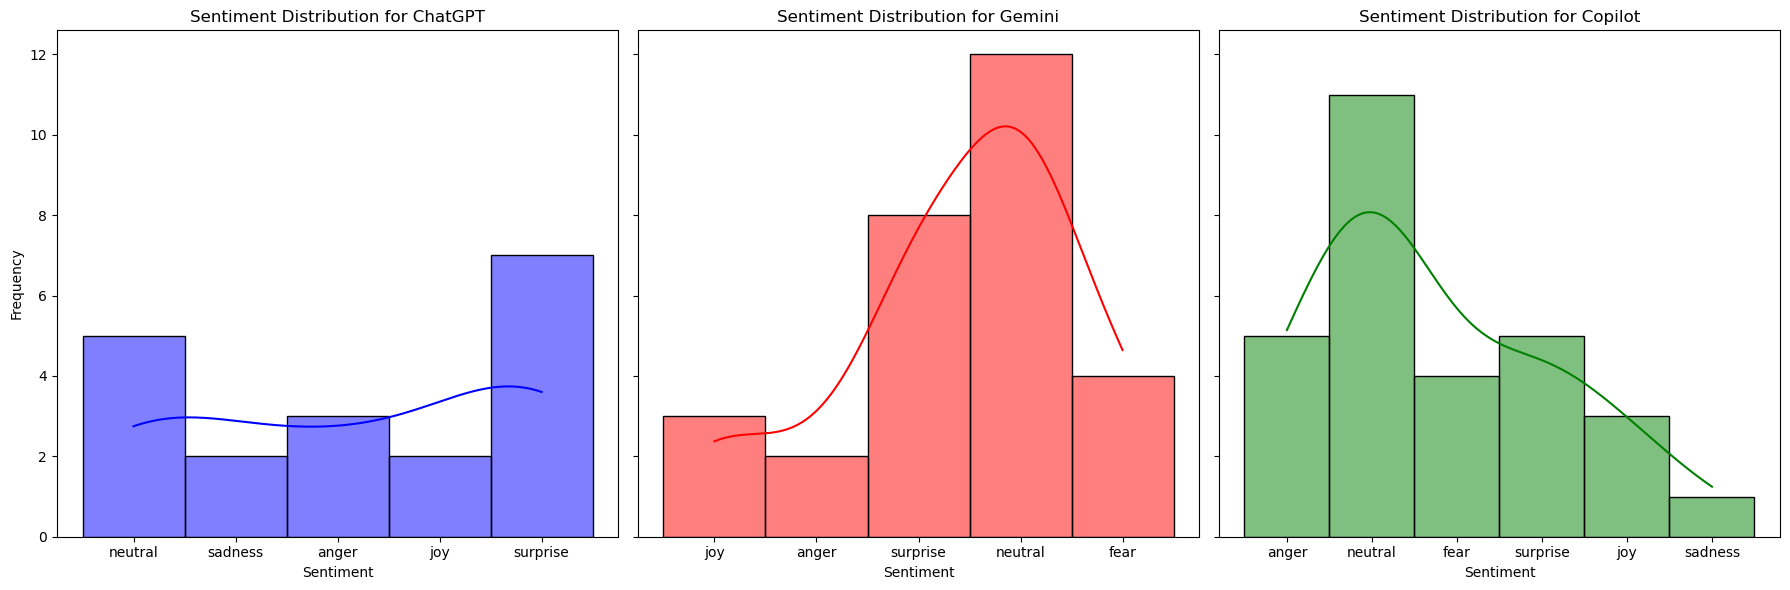

In [70]:
# Plot sentiment distribution for ChatGPT
# Create a figure with 3 subplots side by side
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

# Plot sentiment distribution for ChatGPT
sns.histplot(df_chatgpt['Sentiment'], kde=True, color='blue', ax=axes[0])
axes[0].set_title('Sentiment Distribution for ChatGPT')
axes[0].set_xlabel('Sentiment')
axes[0].set_ylabel('Frequency')

# Plot sentiment distribution for Gemini
sns.histplot(df_gemini['Sentiment'], kde=True, color='red', ax=axes[1])
axes[1].set_title('Sentiment Distribution for Gemini')
axes[1].set_xlabel('Sentiment')
axes[1].set_ylabel('Frequency')

# Plot sentiment distribution for Copilot
sns.histplot(df_copilot['Sentiment'], kde=True, color='green', ax=axes[2])
axes[2].set_title('Sentiment Distribution for Copilot')
axes[2].set_xlabel('Sentiment')
axes[2].set_ylabel('Frequency')

# Adjust layout
plt.tight_layout()
plt.show()

# other hugging face model

In [59]:
# Load sentiment analysis pipeline
model_name = "j-hartmann/emotion-english-distilroberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)
sentiment_pipeline = pipeline("sentiment-analysis", model=model_name)

def truncate_text(text, max_tokens=512):
    tokens = tokenizer.tokenize(text)
    if len(tokens) > max_tokens:
        tokens = tokens[:max_tokens]
    return tokenizer.convert_tokens_to_string(tokens)

def get_sentiment_score(text):
    truncated_text = truncate_text(text)
    result = sentiment_pipeline(truncated_text)[0]
    return result['label'], result['score']

# Apply sentiment analysis
df_chatgpt['Sentiment'], df_chatgpt['Sentiment_Score'] = zip(*df_chatgpt['Body'].apply(get_sentiment_score))
df_gemini['Sentiment'], df_gemini['Sentiment_Score'] = zip(*df_gemini['Body'].apply(get_sentiment_score))
df_copilot['Sentiment'], df_copilot['Sentiment_Score'] = zip(*df_copilot['Body'].apply(get_sentiment_score))

tokenizer_config.json:   0%|          | 0.00/294 [00:00<?, ?B/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


config.json:   0%|          | 0.00/1.00k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/329M [00:00<?, ?B/s]

In [60]:
# Display sentiment statistics
print("ChatGPT Sentiment Statistics:")
print(df_chatgpt['Sentiment'].value_counts(normalize=True))

print("Gemini AI Sentiment Statistics:")
print(df_gemini['Sentiment'].value_counts(normalize=True))

print("Copilot AI Sentiment Statistics:")
print(df_copilot['Sentiment'].value_counts(normalize=True))

ChatGPT Sentiment Statistics:
Sentiment
surprise    0.368421
neutral     0.263158
anger       0.157895
sadness     0.105263
joy         0.105263
Name: proportion, dtype: float64
Gemini AI Sentiment Statistics:
Sentiment
neutral     0.413793
surprise    0.275862
fear        0.137931
joy         0.103448
anger       0.068966
Name: proportion, dtype: float64
Copilot AI Sentiment Statistics:
Sentiment
neutral     0.379310
anger       0.172414
surprise    0.172414
fear        0.137931
joy         0.103448
sadness     0.034483
Name: proportion, dtype: float64


In [62]:
df_chatgpt

,Date,Title,Body,Sentiment,Sentiment_Score
0,2023-04-30 11:06:08,what do you all actually use chatgpt for,chatgpt is cool and has many every now and the...,neutral,0.471515
1,2023-05-23 16:13:52,chatgpt is the devil,four students so far have used chatgpt to writ...,sadness,0.925634
2,2024-04-05 17:57:45,kids think chatgpt is going to save them turni...,love what just happened my students turned in ...,anger,0.721369
3,2024-03-07 21:55:30,chatgpt is a doubleedged sword,tldr tell chatgpt to explain the solution rath...,joy,0.955831
4,2023-04-09 11:07:32,chatgpt assistant chatgpt keyboard for ios use...,last week we shared omni ai while the idea see...,neutral,0.700895
5,2024-03-13 23:02:01,obvious chatgpt prompt reply in published paper,look it up crazy how it good through peer review,surprise,0.772126
6,2024-02-01 17:14:57,chatgpt saved me 250,tldr chatgpt helped me jump start my hybrid to...,neutral,0.471386
7,2023-11-24 15:15:56,chatgpt has become unusably lazy,i asked chatgpt to fill out a csv file of 15 e...,anger,0.386609
8,2023-11-07 15:14:51,top 20 rappers by chatgpt,the question i asked was who are the top 20 be...,surprise,0.500421
9,2023-04-26 17:46:33,video call with chatgpt,hi everyone weve built a realtime video friend...,neutral,0.694812


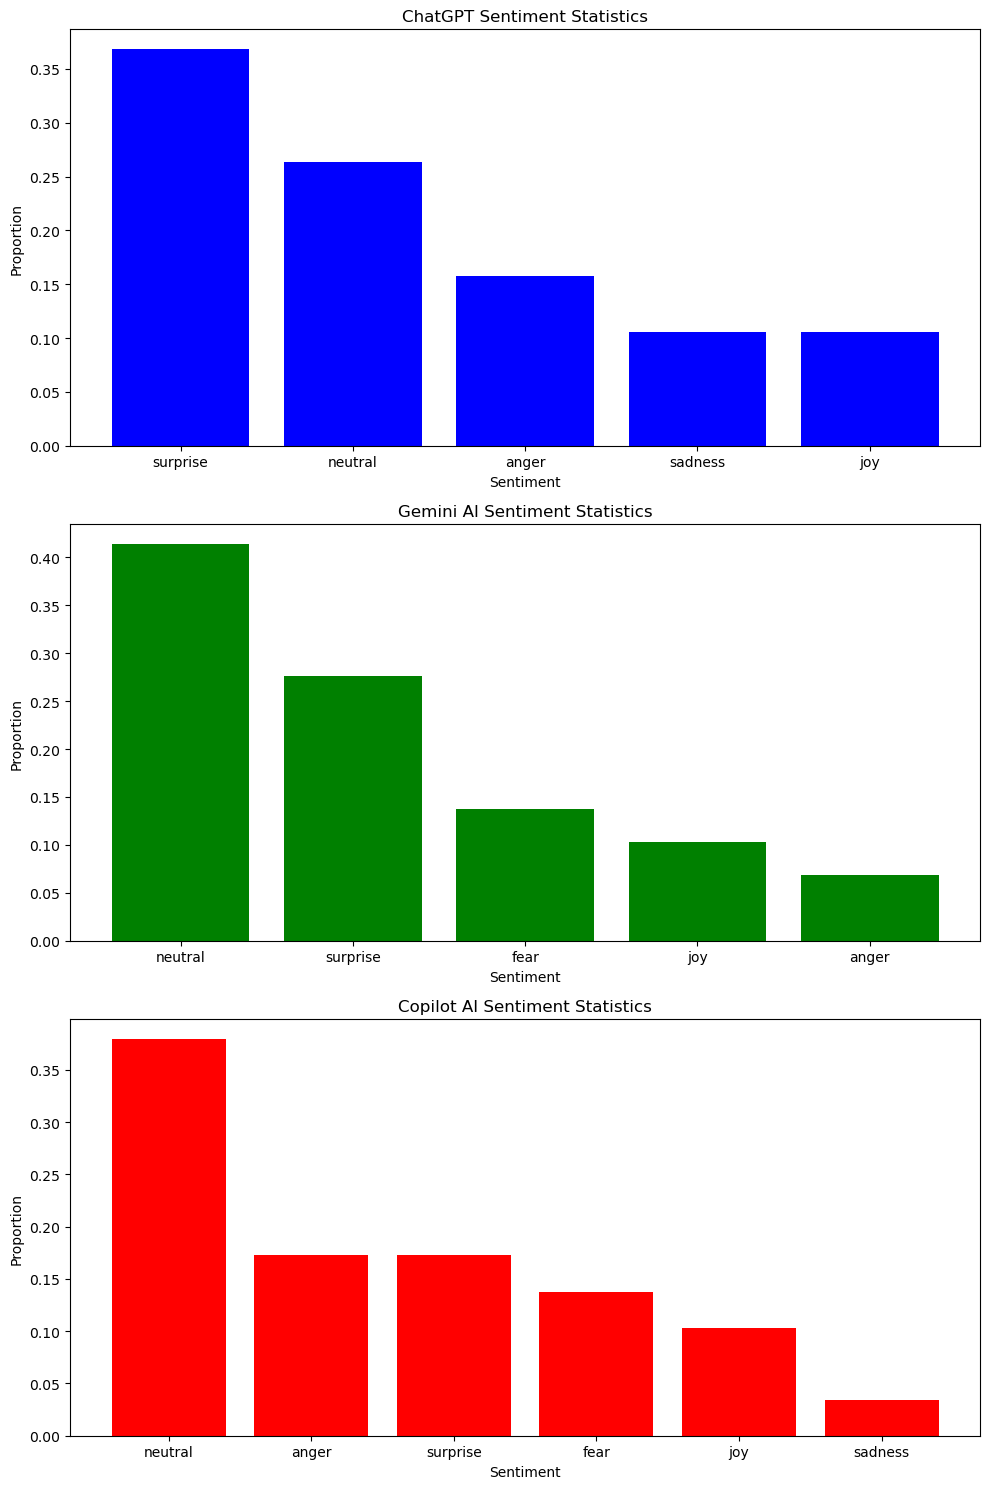

In [61]:

# Prepare the data
chatgpt_sentiment = df_chatgpt['Sentiment'].value_counts(normalize=True)
gemini_sentiment = df_gemini['Sentiment'].value_counts(normalize=True)
copilot_sentiment = df_copilot['Sentiment'].value_counts(normalize=True)

# Plot the sentiment statistics
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 15))

# Plot for ChatGPT
axes[0].bar(chatgpt_sentiment.index, chatgpt_sentiment.values, color='blue')
axes[0].set_title('ChatGPT Sentiment Statistics')
axes[0].set_xlabel('Sentiment')
axes[0].set_ylabel('Proportion')

# Plot for Gemini
axes[1].bar(gemini_sentiment.index, gemini_sentiment.values, color='green')
axes[1].set_title('Gemini AI Sentiment Statistics')
axes[1].set_xlabel('Sentiment')
axes[1].set_ylabel('Proportion')

# Plot for Copilot
axes[2].bar(copilot_sentiment.index, copilot_sentiment.values, color='red')
axes[2].set_title('Copilot AI Sentiment Statistics')
axes[2].set_xlabel('Sentiment')
axes[2].set_ylabel('Proportion')

plt.tight_layout()
plt.show()
